**Import Libraries**

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import hstack

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

**Download the Dataset**

In [5]:
df = pd.read_excel("D:\OneDrive - Lowcode Minds Technology Pvt Ltd\Desktop\customer_review_sentiment_analysing\input\customer_reviews.xlsx")

In [6]:
print("Dataset Loaded")
print("Shape: ", df.shape)
df.head()

Dataset Loaded
Shape:  (500, 4)


,ID,rating,review,sentiment
0,0,5.0,nice,positive
1,1,5.0,"best biryani , so supportive staff of outlet ,...",positive
2,2,4.0,delivery boy was very decent and supportive.ðŸ...,positive
3,3,1.0,"worst biryani i have tasted in my life, half o...",negative
4,4,5.0,all food is good and tasty . will order again ...,positive


**Data Preprocessing**

In [7]:
#Drop unused columns
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [8]:
df.head()

,rating,review,sentiment
0,5.0,nice,positive
1,5.0,"best biryani , so supportive staff of outlet ,...",positive
2,4.0,delivery boy was very decent and supportive.ðŸ...,positive
3,1.0,"worst biryani i have tasted in my life, half o...",negative
4,5.0,all food is good and tasty . will order again ...,positive


In [9]:
df.isnull().sum()

rating       5
review       3
sentiment    3
dtype: int64

In [10]:
# Drop missing reviews
df = df.dropna(subset=["review"])
df.isnull().sum()

rating       2
review       0
sentiment    0
dtype: int64

In [11]:
# Fill missing rates
keyword_rating_map = {
    "excellent": 5,
    "amazing": 5,
    "great": 4,
    "good": 4,
    "decent": 3,
    "okay": 3,
    "average": 3,
    "bad": 2,
    "not good": 2,
    "poor": 1,
    "terrible": 1,
    "disappointed": 1
}

def infer_rating(review):
    review = str(review).lower()
    for word, rating in keyword_rating_map.items():
        if word in review:
            return rating
    return 3

df["rating"] = df.apply(
    lambda row: infer_rating(row["review"]) if pd.isnull(row["rating"]) else row["rating"],
    axis=1
)

In [12]:
df.isnull().sum()

rating       0
review       0
sentiment    0
dtype: int64

**Create Sentiment Labels**

In [13]:
# positive_words = ["good", "best", "excellent", "amazing", "fantastic", "love", "nice", "tasty", "awesome", "superb", "Yummy"]
# negative_words = ["bad", "worst", "disappointed", "poor", "terrible", "horrible", "not good", "late", "cold", "overpriced", "wrong"]

# def get_sentiment_from_review(review):
#     review = str(review).lower()
#     if any(word in review for word in positive_words):
#         return "Positive"
#     elif any(word in review for word in negative_words):
#         return "Negative"
#     else:
#         return "Neutral"
    
# df["sentiment"] = df["review"].apply(get_sentiment_from_review)
print(df["sentiment"].value_counts())

sentiment
positive    212
negative    177
neutral     108
Name: count, dtype: int64


In [14]:
df.head()

,rating,review,sentiment
0,5.0,nice,positive
1,5.0,"best biryani , so supportive staff of outlet ,...",positive
2,4.0,delivery boy was very decent and supportive.ðŸ...,positive
3,1.0,"worst biryani i have tasted in my life, half o...",negative
4,5.0,all food is good and tasty . will order again ...,positive


**Text Cleaning**

In [15]:
def clean_text(text):
    text = text.lower()
    text = str(text)
    text = text.encode('ascii', 'ignore').decode('ascii') # remove emojies and non-ASCII charachters
    text = re.sub(r'<.*?>', ' ', text) # remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces, newlines, tabs
    text = re.sub(r'[^a-zA-Z0-9.,!?\' ]', '', text) # remove special charachters
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

print(df[['rating', 'cleaned_review']])

     rating                                     cleaned_review
0       5.0                                               nice
1       5.0  best biryani , so supportive staff of outlet ,...
2       4.0       delivery boy was very decent and supportive.
3       1.0  worst biryani i have tasted in my life, half o...
4       5.0  all food is good and tasty . will order again ...
..      ...                                                ...
495     5.0                                               nice
496     1.0  sari sabji basi thi rice half bowl bhi nhi tha...
497     1.0                                         worst food
498     1.0  qwantity very less packing like street food bi...
499     5.0                                               good

[497 rows x 2 columns]


In [16]:
df.head()

,rating,review,sentiment,cleaned_review
0,5.0,nice,positive,nice
1,5.0,"best biryani , so supportive staff of outlet ,...",positive,"best biryani , so supportive staff of outlet ,..."
2,4.0,delivery boy was very decent and supportive.ðŸ...,positive,delivery boy was very decent and supportive.
3,1.0,"worst biryani i have tasted in my life, half o...",negative,"worst biryani i have tasted in my life, half o..."
4,5.0,all food is good and tasty . will order again ...,positive,all food is good and tasty . will order again ...


**Stopword Removal**

In [17]:
negation_words = {
    "no", "not", "nor", "never", "n't", "don't", "dont", "cannot", "can't",
    "hardly", "barely", "scarcely", "won't", "wouldn't", "shouldn't", "isn't",
    "wasn't", "aren't", "weren't", "couldn't", "didn't"
}
base_stopwords = set(stopwords.words("english"))
stop_words = base_stopwords - negation_words

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

In [18]:
import nltk
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("averaged_perceptron_tagger")  # you already have this; safe to re-run
nltk.download("wordnet"); nltk.download("omw-1.4")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KawishaNilmani\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
lemmatizer = WordNetLemmatizer()

def _map_pos(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize_text(text: str) -> str:
    tokens = text.split()
    pos_tags = nltk.pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(tok, _map_pos(pos)) for tok, pos in pos_tags]
    return " ".join(lemmas)

df["cleaned_review"] = df["cleaned_review"].apply(lemmatize_text)
df["cleaned_review"] = df["cleaned_review"].apply(remove_stopwords)

In [20]:
df.head()

,rating,review,sentiment,cleaned_review
0,5.0,nice,positive,nice
1,5.0,"best biryani , so supportive staff of outlet ,...",positive,"best biryani , supportive staff outlet , perso..."
2,4.0,delivery boy was very decent and supportive.ðŸ...,positive,delivery boy decent supportive.
3,1.0,"worst biryani i have tasted in my life, half o...",negative,"bad biryani taste life, half biryani dustbin."
4,5.0,all food is good and tasty . will order again ...,positive,food good tasty . order lot explore bawarchi's...


**Train - Test Split**

In [21]:
x = df["cleaned_review"]
y = df["sentiment"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print("Train size: ", x_train.shape[0], " | Test size: ", x_test.shape[0])

Train size:  397  | Test size:  100


**TF-IDF Vectorization**

In [22]:
import scipy.sparse as sp

word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    sublinear_tf=True,
    min_df=1,
    max_df=0.9,
    max_features=None
)

char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(4,5),
    min_df=3
)

xword_train = word_vectorizer.fit_transform(x_train)
xword_test = word_vectorizer.transform(x_test) 

xchar_train = char_vectorizer.fit_transform(x_train)
xchar_test = char_vectorizer.transform(x_test)

x_train_vec = sp.hstack([xword_train, xchar_train]).tocsr()
x_test_vec = sp.hstack([xword_test, xchar_test]).tocsr()

print("Word Vectorization complete. Vocabulary size: ", len(word_vectorizer.get_feature_names_out()))
print("Character Vectorization complete. Vocabulary size: ", len(char_vectorizer.get_feature_names_out()))

Word Vectorization complete. Vocabulary size:  3356
Character Vectorization complete. Vocabulary size:  1045


**Model Training (Logistic Regression)**

In [23]:
model = LogisticRegression(
    max_iter=1000
)
model.fit(x_train_vec, y_train)

LogisticRegression(max_iter=1000)

**Model Evaluation**

In [24]:
y_pred = model.predict(x_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.83

Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.88      0.83        40
     neutral       0.76      0.59      0.67        22
    positive       0.90      0.92      0.91        38

    accuracy                           0.83       100
   macro avg       0.82      0.80      0.80       100
weighted avg       0.83      0.83      0.83       100



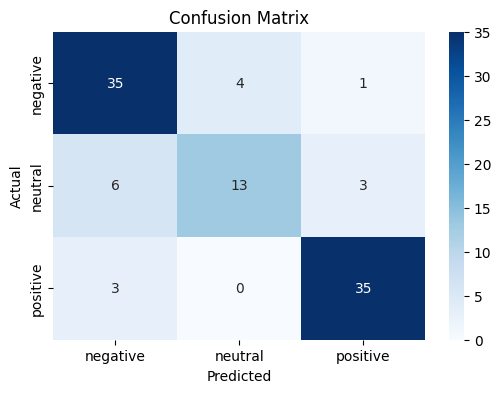

In [25]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Save Model and Vectorizer**

In [26]:
dump(model, "sentiment_model.joblib")
dump(
    {"word": word_vectorizer, "char": char_vectorizer}, "vectorizers.joblib"
)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


**Test**

In [27]:
from joblib import load
import scipy.sparse as sp

bundle = load("vectorizers.joblib")
word_vectorizer = bundle["word"]
char_vectorizer = bundle["char"]
model = load("sentiment_model.joblib")

def prepare_text(text: str) -> str:
    t = clean_text(text)
    # If you added lemmatization, keep this line; otherwise remove it
    t = lemmatize_text(t)
    t = remove_stopwords(t)
    return t

def vectorize_text(text: str):
    t = prepare_text(text)
    Xw = word_vectorizer.transform([t])
    Xc = char_vectorizer.transform([t])
    return sp.hstack([Xw, Xc]).tocsr()

samples = [
    "I don't like this food",
    "The product quality is amazing and the service was great!",
    "ok",
    "humm"
]

CONF_THRESH = 0.50
MIN_TOKENS = 2

for s in samples:
    X = vectorize_text(s)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[0]
        pred = model.classes_[probs.argmax()]
        max_p = probs.max()
    else:
        pred = model.predict(X)[0]
        max_p = 1.0
    tokens = prepare_text(s).split()
    if max_p < CONF_THRESH or len(tokens) < MIN_TOKENS:
        pred = "neutral"
        
    print(f"Sample Review: {s}")
    print(f"Predicted Sentiment: {pred}\n")

Sample Review: I don't like this food
Predicted Sentiment: negative

Sample Review: The product quality is amazing and the service was great!
Predicted Sentiment: positive

Sample Review: ok
Predicted Sentiment: neutral

Sample Review: humm
Predicted Sentiment: neutral



In [28]:
from joblib import load
import scipy.sparse as sp

bundle = load("vectorizers.joblib")
word_vectorizer = bundle["word"]
char_vectorizer = bundle["char"]
model = load("sentiment_model.joblib")

def prepare_text(text: str) -> str:
    t = clean_text(text)
    # If you added lemmatization, keep this line; otherwise remove it
    t = lemmatize_text(t)
    t = remove_stopwords(t)
    return t

def vectorize_text(text: str):
    t = prepare_text(text)
    Xw = word_vectorizer.transform([t])
    Xc = char_vectorizer.transform([t])
    return sp.hstack([Xw, Xc]).tocsr()

samples = [
    "Great foods"
]

CONF_THRESH = 0.50
MIN_TOKENS = 2

for s in samples:
    X = vectorize_text(s)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[0]
        pred = model.classes_[probs.argmax()]
        max_p = probs.max()
    else:
        pred = model.predict(X)[0]
        max_p = 1.0
    tokens = prepare_text(s).split()
    if max_p < CONF_THRESH or len(tokens) < MIN_TOKENS:
        pred = "neutral"
        
    print(f"Sample Review: {s}")
    print(f"Predicted Sentiment: {pred}\n")

Sample Review: Great foods
Predicted Sentiment: positive

